In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import array as arr
import torch
from obspy.clients.fdsn.client import Client
from functools import reduce
from datetime import datetime


# %pip install eqtransformer
# %pip install adjustText
# %pip install openpyxl

In [8]:
# Use GPU
torch.cuda.is_available()

False

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
# Read Morton's catalog
cat_ds03 = pd.read_excel("/wd1/hbito_data/data/ds03.xlsx")

In [11]:
# Show the catalog
cat_ds03

,CI YEAR,CLUSTER ID,STATION,NETWORK CODE,FILTER USED (Hz)
0,1,OC1,J25A,7D,HP 5
1,1,NaN,M08A,7D,HP 5
2,1,NaN,I02D,TA,HP 5
3,1,OC2,J25A,7D,BP 5-10
4,1,NaN,J33A,7D,BP 5-15
...,...,...,...,...,...
247,4,CI4-45,FC03D,7D,BP 1-15
248,4,NaN,HEBO,UW,BP 2-10
249,4,CI4-47,NLWA,US,HP 3
250,4,CI4-48,OCP,UW,BP 3-10


In [12]:
# Get the names of the networks
cat_ds03_CI2 = cat_ds03[cat_ds03['CI YEAR']==2]
cat_ds03_CI2

,CI YEAR,CLUSTER ID,STATION,NETWORK CODE,FILTER USED (Hz)
49,2,SM,I02D,TA,HP 5
50,2,NaN,M09B,7D,BP 5-10
51,2,NaN,J25B,7D,HP 5
52,2,Nclust,J25B,7D,HP5
53,2,NaN,J33B,7D,BP 2-10
...,...,...,...,...,...
111,2,NaN,KEB,NC,BP 3-10
112,2,CI2-27,J09B,7D,HP 5
113,2,NaN,J01E,TA,HP 5
114,2,CI2-28,BABR,UW,HP 5


In [13]:
# Show unique network codes in CI year 2
cat_ds03_CI2['NETWORK CODE'].unique()

array(['TA', '7D', 'UW', 'NC', 'BK'], dtype=object)

In [14]:
# Assign the network codes
networks= cat_ds03_CI2['NETWORK CODE'].unique()

In [15]:
sta = cat_ds03_CI2.loc[cat_ds03_CI2['NETWORK CODE']=='7D', 'STATION']
sta = [i.replace(" ", "") for i in sta]
sta = set(sta)
sta =list(sta)
len(sta)

17

In [16]:
# Make a list of networks and stations
networks_stas = []
for i in range(len(networks)):
    network = networks[i]
    sta = cat_ds03_CI2.loc[cat_ds03_CI2['NETWORK CODE']==network, 'STATION']
    
    sta = [i.replace(" ", "") for i in sta]
    sta = set(sta)
    sta =list(sta)

    for j in range(len(sta)):
        networks_stas.append([network,sta[j]])

networks_stas =np.array(networks_stas)
networks_stas

array([['TA', 'I02D'],
       ['TA', 'J01E'],
       ['7D', 'M14B'],
       ['7D', 'M12B'],
       ['7D', 'G10B'],
       ['7D', 'G17B'],
       ['7D', 'J33B'],
       ['7D', 'FS09B'],
       ['7D', 'G25B'],
       ['7D', 'G27B'],
       ['7D', 'M09B'],
       ['7D', 'J25B'],
       ['7D', 'FS13B'],
       ['7D', 'FS17B'],
       ['7D', 'FS16B'],
       ['7D', 'FS20B'],
       ['7D', 'G19B'],
       ['7D', 'J09B'],
       ['7D', 'G26B'],
       ['UW', 'I02D'],
       ['UW', 'BABR'],
       ['NC', 'KHBB'],
       ['NC', 'KHMB'],
       ['NC', 'KSXB'],
       ['NC', 'KMPB'],
       ['NC', 'KEB'],
       ['NC', 'KOM'],
       ['NC', 'KRMB'],
       ['NC', 'KBO'],
       ['BK', 'JCC']], dtype='<U5')

In [17]:
test = np.zeros((5,2))
test[:,0]

array([0., 0., 0., 0., 0.])

In [18]:
# Convert station series to a list
# stations= (cat_ds03_CI2['STATION'].unique()).tolist()
# stations

In [19]:
networks_stas[:,1]

array(['I02D', 'J01E', 'M14B', 'M12B', 'G10B', 'G17B', 'J33B', 'FS09B',
       'G25B', 'G27B', 'M09B', 'J25B', 'FS13B', 'FS17B', 'FS16B', 'FS20B',
       'G19B', 'J09B', 'G26B', 'I02D', 'BABR', 'KHBB', 'KHMB', 'KSXB',
       'KMPB', 'KEB', 'KOM', 'KRMB', 'KBO', 'JCC'], dtype='<U5')

In [20]:
# Delete the spaces in the station code strings.
for i in range(len(stations)):
    s = stations[i]
    stations[i]= s.replace(" ", "")
        
stations

NameError: name 'stations' is not defined

In [21]:
# Converge the all the strings to a single string listing the stations delimited by commas with no spaces 

delim = ","
 
stations = reduce(lambda x, y: str(x) + delim + str(y), stations)
 
stations

NameError: name 'stations' is not defined

In [22]:
# Get station inventory from obspy
stations = stations
network = '7D'
channels = 'HH*'
client = Client("IRIS")
inventory = client.get_stations(network=network, station=stations)

NameError: name 'stations' is not defined

In [13]:
start_dates = [] # Make a list to contain all the start dates 
end_dates = [] # Make a list to contain all the end dates 
latitudes = np.zeros(len(inventory[0])) # Make a list to contain all the latitudes

for i in range(len(inventory[0])): 
    start_dates.append(inventory[0][i].start_date.datetime)
    end_dates.append(inventory[0][i].end_date.datetime)
    latitudes[i] = inventory[0][i].latitude

# Find the latitudes less than 42 degrees. 
a = latitudes
index_lat_less_than_42 = np.asarray(np.where(42 >= a))
print(type(index_lat_less_than_42))

latitudes = latitudes.tolist()

# Convert inventory to a np.array
inventory_codes = []
for i in range(len(inventory[0])):
    inventory_codes.append(inventory[0][i].code)

<class 'numpy.ndarray'>


In [14]:
# Filter stations by deployment dates
t1 = datetime(2012,7, 1)
t2 = datetime(2012,12, 31)
keep = [i for i,e in enumerate(start_dates) if (e > t1) and (e < t2)]
filtered_stations = [inventory_codes[i] for i in keep]

In [98]:
start_dates = [] # Make a list to contain all the start dates 
end_dates = [] # Make a list to contain all the end dates 
latitudes = np.zeros(len(networks_stas[0])) # Make a list to contain all the latitudes
inventory_codes = []

for i in range(len(networks_stas)):
    network = networks_stas[i,0]
    station = networks_stas[i,1]
    channels = 'HH*'
    client = Client("IRIS")
    inventory = client.get_stations(network=network, station=station)
    print(inventory[0])
    start_dates.append(inventory[0].start_date.datetime)
    if inventory[0].end_date == None
        end_dates.append
    end_dates.append(inventory[0].end_date.datetime)
    latitudes[i] = inventory[0].latitude
    inventory_codes.append(inventory[0].code)
    

None


AttributeError: 'NoneType' object has no attribute 'datetime'

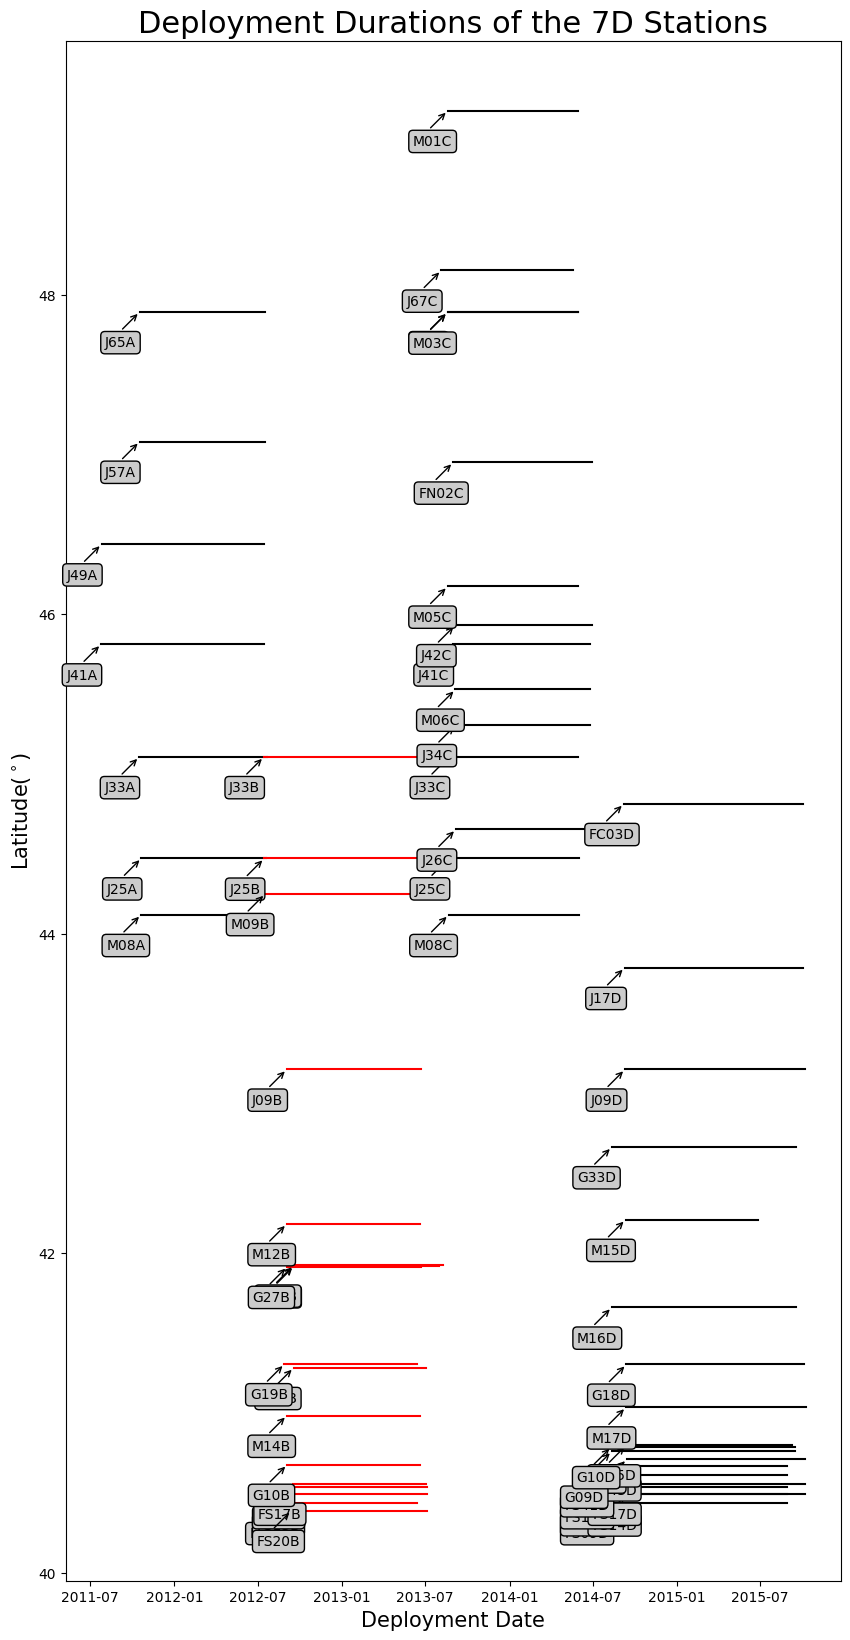

In [15]:
#  Plot the stations one more time to see if the previous code was right
# Plot the start and end dates with respect to the latitudes
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=45,rad=10")

offset = 25


plt.figure(figsize=(10,20))
for i in range(len(inventory_codes)):
    if (start_dates[i] > t1) and (start_dates[i] < t2):
        plt.plot([start_dates[i], end_dates[i]],[latitudes[i],latitudes[i]], color='r', label=str(inventory[0][i].code))
        plt.annotate(text=str(inventory[0][i].code), xy=(start_dates[i],latitudes[i]), xytext=(-1*offset,-1*offset),textcoords='offset points',
        bbox=bbox, arrowprops=arrowprops)
        
    else:
        plt.plot([start_dates[i], end_dates[i]],[latitudes[i],latitudes[i]], color='black', label=str(inventory[0][i].code))
        plt.annotate(text=str(inventory[0][i].code), xy=(start_dates[i],latitudes[i]), xytext=(-1*offset,-1*offset),textcoords='offset points',
        bbox=bbox, arrowprops=arrowprops)
        
plt.xlabel("Deployment Date",fontsize=15)
plt.ylabel("Latitude($^\circ$)", fontsize=15)
# plt.ylim(40,46)
# plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title("Deployment Durations of the 7D Stations",fontsize=22)

plt.show()

In [18]:
inventory[0][0]

Station FC03D (LDEO OBS TRAWL-RESISTANT)
	Station Code: FC03D
	Channel Count: 0/9 (Selected/Total)
	2014-09-07T00:00:00.000000Z - 2015-10-02T23:59:59.000000Z
	Access: open 
	Latitude: 44.8133, Longitude: -124.7383, Elevation: -432.0 m
	Available Channels:


In [23]:
# Add the location and elevation information along to the station ID's
all_stations = pd.DataFrame(columns=['id','longitude','latitude', 'elevation'])
for i in inventory[0]:
    print(i.code,i.latitude, i.longitude,i.elevation)
    temp = pd.DataFrame(data={'id': i.code,'longitude':i.longitude,'latitude':i.latitude, 'elevation':i.elevation},index=[0])
    all_stations = pd.concat([all_stations,temp],ignore_index=True)

FC03D 44.813301 -124.738297 -432.0
FN02C 46.949699 -124.428001 -67.0
FS09B 40.438702 -124.808502 -2161.0
FS09D 40.437698 -124.803703 -2122.1
FS13B 40.493099 -124.806503 -2332.0
FS13D 40.493698 -124.803398 -2291.2
FS14D 40.492298 -124.603897 -145.0
FS16B 40.538101 -124.739502 -1073.0
FS16D 40.5378 -124.746803 -1080.4
FS17B 40.559799 -124.596497 -146.0
FS17D 40.559799 -124.597 -145.0
FS20B 40.3895 -125.031097 -2378.0
FS41D 40.6124 -124.731003 -1079.3
FS43D 40.711899 -124.5839 -719.0
FS44D 40.760899 -124.702797 -837.0
FS45D 40.799999 -124.520302 -477.0
G09D 40.6665 -124.726898 -716.3
G10B 40.677898 -125.553299 -2936.0
G10D 40.788799 -125.554398 -3015.0
G17B 41.283901 -124.344597 -123.0
G18D 41.304699 -125.255798 -3130.0
G19B 41.3074 -125.773598 -3071.0
G25B 41.919899 -124.586098 -430.0
G26B 41.9249 -125.177498 -2357.0
G27B 41.916599 -126.016701 -3480.0
G33D 42.665298 -124.802002 -686.0
J09B 43.151001 -124.726997 -252.0
J09D 43.151402 -124.727097 -252.0
J17D 43.7873 -124.613403 -285.0
J25A

/tmp/ipykernel_1908306/2071541923.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stations = pd.concat([all_stations,temp],ignore_index=True)


In [24]:
all_stations

,id,longitude,latitude,elevation
0,FC03D,-124.738297,44.813301,-432.0
1,FN02C,-124.428001,46.949699,-67.0
2,FS09B,-124.808502,40.438702,-2161.0
3,FS09D,-124.803703,40.437698,-2122.1
4,FS13B,-124.806503,40.493099,-2332.0
5,FS13D,-124.803398,40.493698,-2291.2
6,FS14D,-124.603897,40.492298,-145.0
7,FS16B,-124.739502,40.538101,-1073.0
8,FS16D,-124.746803,40.537800,-1080.4
9,FS17B,-124.596497,40.559799,-146.0


In [ ]:
all_stations.to_csv("/wd1/hbito_data/data/datasets_all_regions/stations_october.csv")